# Uninsured Racial Disparity, Blood Pressure Gender & Smoker Diffs

In a previous post, I examined baby circadian clocks, specifically the difference in night bedtime and sleep duration between napping and non-napping babies (https://crawstat.com/2020/06/04/baby-circadian-clocks/). Today, I'll work with the National Health and Nutrition Examination Survey (NHANES) 2016 dataset. NHANES is a yearly national cross-sectional study conducted by the CDC that asssses the health of the U.S. population (https://www.cdc.gov/nchs/nhanes/index.htm), collecting thousands of health, diet, demographic, and socioeconomic variables. I'll use it to answer  four questions:

**Question 1**: What is the difference in systolic blood pressure (mmHg) between men and women in the U.S.? 
<br>**Question 2**: What proportion of black (non-hispanic) Americans has been uninsured in the past year? 
<br>**Question 3**. How much greater is the proportion of black (non-hispanic) uninsured in the past year compared to white (non-hispanic) Americans? 
<br>**Question 4**: What is the difference in the proportion of U.S. smokers and non-smokers that are hypertensive (systolic blood pressure >130 mmHg)?  

In this analysis, I formulate clear, focused questions that detail our target populations and parameters, hypotheses, alpha, and assumptions upfront. This part is super-important in order to perform a high quality analysis, draw the right conclusions, and not go down rabbit holes. A key difference here compared to my previous post is that for questions 2, 3, and 4, we'll work with difference in proportion of categorical data (not difference in mean of continuous data), which requires a bit more transformation and subsetting to get at the data we need to answer our questions. I walk through subsetting and creating relevant dataframes for each analysis using pd.groupby, pd.crosstab, and pd.cut and applying numpy and statsmodels functions for analysis. I use simplifying assumptions of random, independent sampling and normally distributed populations with similar variances (pooled standard error). 

To answer Question 1, we use pd.groupby and .agg to group and aggregate data by gender and a 2-sided P-value using 1-t.cdf and sm.stats.ttest_ind. To answer Question 2, we use pd.crosstab to group by ethnicity and calculate a 95% confidence interval using both sm.stats.proportion_confint and generating lower and upper confidence bounds manually. To answer Question 3, we calculate a 1-sided P-value using 1-t.cdf, t.sf, and sm.stats.ttest_ind (and halving the result). To answer Question 4, we calculate a 2-sided P-value using 1-t.cdf and sm.stats.ttest_ind. For pooled standard error, we use pd.concat to combine dataframes. Importantly, throughout, I walk through how to interpret and communicate results and conclusions. In future posts, I will take our analysis a step further and fit linear and logistic regression models to uncover associations and make predictions. 

In [2]:
# Import relevant libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from scipy.stats import t
import numpy as np
import scipy.stats.distributions as dist

In [3]:
# Read the data set and have a look at the first few rows to a get a feel for it
pd.set_option("display.max_columns", 100)
da = pd.read_csv("https://raw.githubusercontent.com/kshedden/statswpy/master/NHANES/merged/nhanes_2015_2016.csv")
da.head(5)

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDMARTL,DMDHHSIZ,WTINT2YR,SDMVPSU,SDMVSTRA,INDFMPIR,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
0,83732,1.0,NaN,1.0,1,1,62,3,1.0,5.0,1.0,2,134671.37,1,125,4.39,128.0,70.0,124.0,64.0,94.8,184.5,27.8,43.3,43.6,35.9,101.1,2.0
1,83733,1.0,NaN,6.0,1,1,53,3,2.0,3.0,3.0,1,24328.56,1,125,1.32,146.0,88.0,140.0,88.0,90.4,171.4,30.8,38.0,40.0,33.2,107.9,NaN
2,83734,1.0,NaN,NaN,1,1,78,3,1.0,3.0,1.0,2,12400.01,1,131,1.51,138.0,46.0,132.0,44.0,83.4,170.1,28.8,35.6,37.0,31.0,116.5,2.0
3,83735,2.0,1.0,1.0,2,2,56,3,1.0,5.0,6.0,1,102718.00,1,131,5.00,132.0,72.0,134.0,68.0,109.8,160.9,42.4,38.5,37.7,38.3,110.1,2.0
4,83736,2.0,1.0,1.0,2,2,42,4,1.0,4.0,3.0,5,17627.67,2,126,1.23,100.0,70.0,114.0,54.0,55.2,164.9,20.3,37.4,36.0,27.2,80.4,2.0


In [4]:
# Have a look at the last few rows (the data includes 5,734 observations)
da.tail(5)

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,DMDMARTL,DMDHHSIZ,WTINT2YR,SDMVPSU,SDMVSTRA,INDFMPIR,BPXSY1,BPXDI1,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
5730,93695,2.0,2.0,NaN,1,2,76,3,1.0,3.0,2.0,1,58614.08,2,130,1.43,112.0,48.0,112.0,46.0,59.1,165.8,21.5,38.2,37.0,29.5,95.0,2.0
5731,93696,2.0,2.0,NaN,2,1,26,3,1.0,5.0,1.0,3,122920.60,1,121,2.99,118.0,68.0,116.0,76.0,112.1,182.2,33.8,43.4,41.8,42.3,110.2,2.0
5732,93697,1.0,NaN,1.0,1,2,80,3,1.0,4.0,2.0,1,49050.06,2,132,2.97,154.0,56.0,146.0,58.0,71.7,152.2,31.0,31.3,37.5,28.8,NaN,2.0
5733,93700,NaN,NaN,NaN,1,1,35,3,2.0,1.0,1.0,5,42314.29,1,126,0.00,104.0,62.0,106.0,66.0,78.2,173.3,26.0,40.3,37.5,30.6,98.9,2.0
5734,93702,1.0,NaN,2.0,2,2,24,3,1.0,5.0,5.0,3,107361.91,2,119,3.54,118.0,66.0,114.0,68.0,58.3,165.0,21.4,38.2,33.5,26.2,72.5,2.0


In [5]:
# Check the column headings
da.columns

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'WTINT2YR',
       'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2',
       'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC',
       'BMXWAIST', 'HIQ210'],
      dtype='object')

In [6]:
# Check the dimensions of the dataframe, this one has 5,735 rows and 28 columns
da.shape

(5735, 28)

In [7]:
# Check number of null values by variable
da.isnull().sum()

SEQN           0
ALQ101       527
ALQ110      4004
ALQ130      2356
SMQ020         0
RIAGENDR       0
RIDAGEYR       0
RIDRETH1       0
DMDCITZN       1
DMDEDUC2     261
DMDMARTL     261
DMDHHSIZ       0
WTINT2YR       0
SDMVPSU        0
SDMVSTRA       0
INDFMPIR     601
BPXSY1       334
BPXDI1       334
BPXSY2       200
BPXDI2       200
BMXWT         69
BMXHT         62
BMXBMI        73
BMXLEG       390
BMXARML      308
BMXARMC      308
BMXWAIST     367
HIQ210      1003
dtype: int64

In [8]:
# Create new gender column using more easily interpretable variables (instead of numeric responses)
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

In [9]:
# Create new ethnicity column using more easily interpretable variables (instead of numeric responses)
da["RIDRETH1x"] = da.RIDRETH1.replace({1: "Mex Amer", 2: "Other Hisp", 3: "Non Hisp White", 4: "Non Hisp Black", 5: "Other"})

In [10]:
# Create new non-insurance column using more easily interpretable variables (instead of numeric responses)
da["HIQ210x"] = da.HIQ210.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

In [11]:
# Create new smoking status column using more easily interpretable variables (instead of numeric responses)
da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

In [12]:
# Create new systolic blood pressure group column using pd.cut to categorize 0-90 mmHg as low, 90-130 mmHg as normal, and 130 mmHg to infinity as high. 
# Use the 2nd blood pressure measurement BPXSY2 instead of the 1st measurement BPXSY1 to try to avoid "whitecoat effect" of elevated blood pressure. 
bins = [0, 90, 130, np.inf]
names = ["low", "normal", "high"]
da["bpgrp"] = pd.cut(da["BPXSY2"], bins, labels = names)

In [13]:
keep = ['SMQ020x','RIAGENDRx', 'RIDAGEYR', 'RIDRETH1x', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 
       'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2',
       'BPXDI2', "bpgrp",'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC',
       'BMXWAIST', 'HIQ210x']

In [14]:
# Create new dataframe health with select variables, drop null values with .dropna()
health = da[keep].dropna()
health.head(5)

,SMQ020x,RIAGENDRx,RIDAGEYR,RIDRETH1x,DMDEDUC2,DMDMARTL,DMDHHSIZ,INDFMPIR,BPXSY1,BPXDI1,BPXSY2,BPXDI2,bpgrp,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210x
0,Yes,Male,62,Non Hisp White,5.0,1.0,2,4.39,128.0,70.0,124.0,64.0,normal,94.8,184.5,27.8,43.3,43.6,35.9,101.1,No
2,Yes,Male,78,Non Hisp White,3.0,1.0,2,1.51,138.0,46.0,132.0,44.0,high,83.4,170.1,28.8,35.6,37.0,31.0,116.5,No
3,No,Female,56,Non Hisp White,5.0,6.0,1,5.00,132.0,72.0,134.0,68.0,high,109.8,160.9,42.4,38.5,37.7,38.3,110.1,No
4,No,Female,42,Non Hisp Black,4.0,3.0,5,1.23,100.0,70.0,114.0,54.0,normal,55.2,164.9,20.3,37.4,36.0,27.2,80.4,No
7,No,Female,32,Mex Amer,4.0,1.0,4,1.03,120.0,70.0,114.0,70.0,normal,64.5,151.3,28.2,34.1,33.1,31.5,93.3,No


In [15]:
# Check shape of new dataframe
health.shape

(3567, 21)

In [16]:
# Check data types
health.dtypes

SMQ020x        object
RIAGENDRx      object
RIDAGEYR        int64
RIDRETH1x      object
DMDEDUC2      float64
DMDMARTL      float64
DMDHHSIZ        int64
INDFMPIR      float64
BPXSY1        float64
BPXDI1        float64
BPXSY2        float64
BPXDI2        float64
bpgrp        category
BMXWT         float64
BMXHT         float64
BMXBMI        float64
BMXLEG        float64
BMXARML       float64
BMXARMC       float64
BMXWAIST      float64
HIQ210x        object
dtype: object

In [17]:
# We're going to be using seaborn for plots, set style to darkgrid
sns.set_style("darkgrid")

Before I dive into the questions, I explore select data a bit to get a feel for it and understand shapes of distrubitions and spreads. 

The histogram illustrates that systolic and diastolic blood pressure is roughly normally distributed (aligned with our assumption at the top)

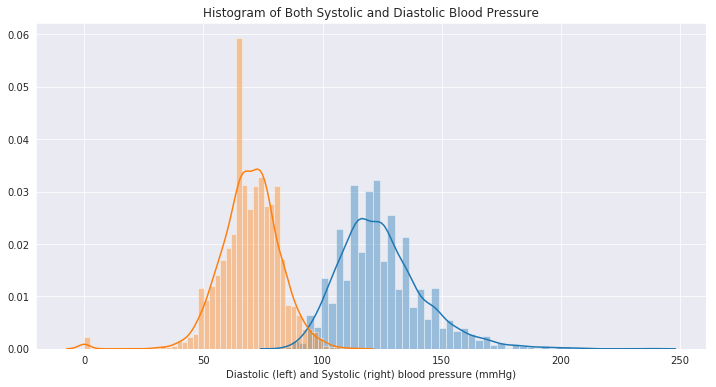

In [18]:
# Distribution of both systolic and diastolic blood pressure. 
plt.figure(figsize=(12, 6))
sns.distplot(health.BPXSY2)
sns.distplot(health.BPXDI2)
plt.title("Histogram of Both Systolic and Diastolic Blood Pressure")
plt.xlabel("Diastolic (left) and Systolic (right) blood pressure (mmHg)")
plt.show()

Text(0, 0.5, 'Blood pressure in mm/Hg')

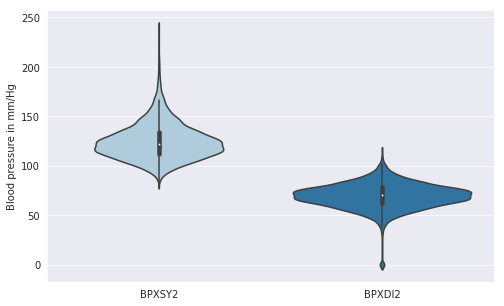

In [91]:
# Box plot of systolic and diastolic blood pressure to visualize spread 
plt.figure(figsize=(8, 5))
sns.violinplot(data=health.loc[:, ["BPXSY2", "BPXDI2"]], palette = "Paired")
plt.ylabel("Blood pressure in mm/Hg")

In [20]:
# Summary statistics of systolic blood pressure
print(health["BPXSY2"].describe())

count    3567.000000
mean      124.614522
std        17.838411
min        84.000000
25%       112.000000
50%       122.000000
75%       134.000000
max       238.000000
Name: BPXSY2, dtype: float64


In [21]:
# Summary statistics of diastolic blood pressure
print(health["BPXDI2"].describe())

count    3567.000000
mean       69.543594
std        12.515666
min         0.000000
25%        62.000000
50%        70.000000
75%        78.000000
max       114.000000
Name: BPXDI2, dtype: float64


From the box plot below, it looks like there's an increasing trend in median and spread of systolic blood pressure with age for both men and women. 

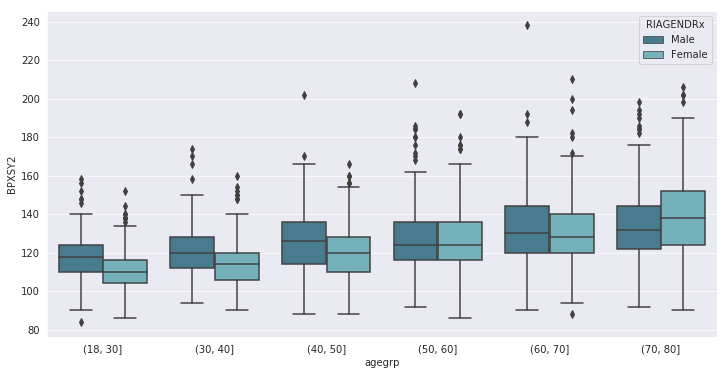

In [89]:
# Box plot of systolic blood pressure stratified by both age and gender. I create age subranges using pd.cut
health["agegrp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
plt.figure(figsize=(12, 6))
sns.boxplot(x="agegrp", y="BPXSY2", hue="RIAGENDRx", data=health, palette = "GnBu_d")

In the scatterplots below, it looks like there's a moderate upward correlation between systolic and diastolic blood pressure for men and women and ethnic groups. 

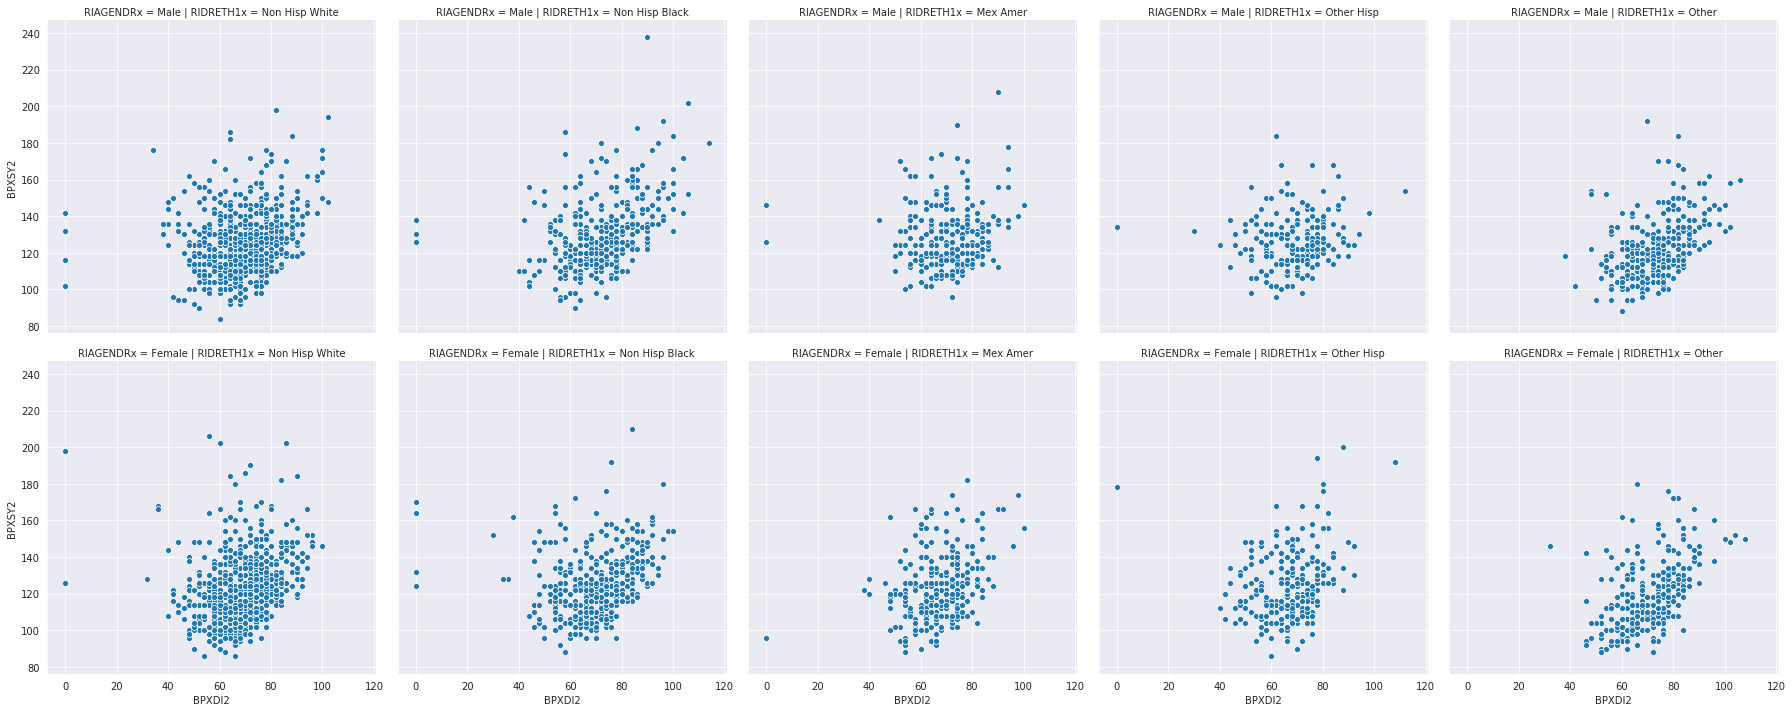

In [23]:
# Scatter plot of systolic to diastolic blood pressure stratified by gender (rows) and ethnicity (columns)
sns.relplot(x="BPXDI2", y="BPXSY2", data=health, row = "RIAGENDRx", col = "RIDRETH1x")

Hypothesis test and conf interval for diff in proportion of blacks and whites being uninsured in the past year 

## Question 1: What is the difference in systolic blood pressure (mmHg) between men and women in the U.S.? 

To answer this, I'll use a hypothesis test. Our null hypothesis is that the average systolic blood pressure is the same for both populations of men and women, while our alternative hypothesis is the average systolic blood pressure is different for men and women.

**Population 1**: All men in the U.S.
<br>**Population 2**: All women in the U.S.
<br>**Parameter**: μ1−μ2, systolic blood pressure in mmHg
<br>**Null Hypothesis**: μ1−μ2 = 0
<br>**Alternative Hypothesis**: μ1−μ2 ≠ 0 (2-sided test so we'll need a 2-sided p-value)
<br>**α** = 0.05
<br>**Assumptions**: Random independent sample, variance similar among groups, roughly normal population distribution

#### Method 1: Calculate the 2-sided p-value using t.cdf ("cumulative density function")

In [24]:
# First, let's check summary stats by grouping by gender using pd.groupby and .agg to aggregate data for all values in the group
health.groupby("RIAGENDRx").agg({"BPXSY2":[np.mean, np.std, np.size]})

BPXSY2                   
                 mean        std    size
RIAGENDRx                               
Female     122.773950  18.135181  1858.0
Male       126.615565  17.294400  1709.0

In [25]:
# First, let's create new dataframes for blood pressure for men and women
health_men = health.loc[health.RIAGENDRx == "Male", "BPXSY2"]
health_women = health.loc[health.RIAGENDRx == "Female", "BPXSY2"]

In [26]:
# Mean systolic blood pressure for men
health_men_mean = health_men.mean()
print(health_men_mean)

126.61556465769456


In [27]:
# Mean systolic blood pressure for women
health_women_mean = health_women.mean()
print(health_women_mean)

122.77395048439182


In [28]:
diff_mean = health_men_mean - health_women_mean
print(diff_mean)

3.8416141733027445


In the sample, men have an average systolic blood pressure 3.84 mmHg higher than that of women. 

In [29]:
# Sample size of men
n1 = len(health_men)
print(n1)

1709


In [30]:
# Sample size of women
n2 = len(health_women)
print(n2)

1858


In [31]:
# Standard deviation of blood pressure for men
s1 = health_men.std()
print(s1)

17.294399906855233


In [32]:
# Standard deviation of blood pressure for women
s2 = health_women.std()
print(s2)

18.135181064643813


As we highlighted above, we'll make the simplifying assumption that the variance among men and women is about the same so we can use the pooled standard error (in the future, we'll apply other methods without this assumption):

$s.e.(\bar{X}_{men} - \bar{X}_{women}) = \sqrt{\frac{(n_1-1)s_1^2 + (n_2-1)s_2^2}{n_1+n_2-2}(\frac{1}{n_1}+\frac{1}{n_2})}$

In [33]:
# Pooled standard error
pooled_se = np.sqrt((((n1-1)*(s1**2)+(n2-1)*(s2**2))/(n1+n2-2))*((1/n1)+(1/n2)))
print(pooled_se)

0.5944920175958089


In [34]:
# Calculate T-Statistic, or the number of standard error bars we are from the null hypothesis mean difference of 0
t_statistic = diff_mean/pooled_se
print(t_statistic)

6.46201136364901


In [35]:
# Calculate degrees of freedom. Since we're using two samples, we'll subtract 2
df = n1 + n2 - 2
print(df)

3565


In [36]:
# Calculate 2-sided p-value using 1-t.cdf(np.abs(T-statistic), df) * 2
p_value = (1-t.cdf(np.abs(t_statistic), df))*2
print(p_value)

1.1732281812726342e-10


#### Method 2: Calculate the p-value using sm.stats.ttest_ind

In [37]:
# Calculate T-statistic and 2-sided P-value automatically using sm.stats.ttest_ind.
print("T-statistic, P-value, df")
sm.stats.ttest_ind(health_men, health_women)

T-statistic, P-value, df


(6.462011363649024, 1.1732294260404243e-10, 3565.0)

Both methods generate a tiny p-value at nearly 0, meaning that, if our null hypothesis is true (men and women have the same systolic blood pressure), there's a tiny probability of nearly 0 that we would have gotten a difference in systolic blood pressure like the one we from our statistical sample. 

Our p-value is less than our $\alpha$ = 0.05, meaning, that based on our evidence, we can reject our null hypothesis and say that men in the U.S. have a systolic blood pressure roughly 4 mmHg higher than that of women in the U.S. 

## Question 2: What proportion of black (non-hispanic) Americans has been uninsured in the past year?

#### Method 1: Calculate 95% CI using sm.stats.proportion_confint

In [38]:
# Frequency table for joint distributions of RIDRETH1x and HIQ210x, normalize results 

Before we dig in, let's have a quick look at how the total numbers look by ethnic group for being uninsured in the past year ("Yes" being the person was uninsured in the past year). We use pd.crosstab on ethnicity and insurance status to check frequency of responses. 

In [39]:
pd.crosstab(health.RIDRETH1x, health.HIQ210x)

HIQ210x,No,Yes
RIDRETH1x,,
Mex Amer,424,70
Non Hisp Black,653,91
Non Hisp White,1234,97
Other,507,54
Other Hisp,375,62


At first glance at the proportions we below, it seems like the proportion of black (non-hispanic) Americans uninsured is higher than that of white (non-hispanic) Americans. Let's see if we can make an inference for the whole population by generating a confidence interval. 

In [40]:
# We could actually have a quick look at the proportion in table form
# Here, we normalize the results above using a lambda function so that values within each ethnic group sum to 1
pd.crosstab(health.RIDRETH1x, health.HIQ210x).apply(lambda x: x/x.sum(), axis=1)

HIQ210x,No,Yes
RIDRETH1x,,
Mex Amer,0.858300,0.141700
Non Hisp Black,0.877688,0.122312
Non Hisp White,0.927122,0.072878
Other,0.903743,0.096257
Other Hisp,0.858124,0.141876


In [41]:
# Create dataframes for both ethnic groups and insurance response. 
# As the target parameter is a proportion and not a mean, we can change Yes to 1 and No to 0 to easily calculate proportions
black = health.loc[health.RIDRETH1x=="Non Hisp Black", "HIQ210x"].replace({"Yes":1, "No":0})
white = health.loc[health.RIDRETH1x=="Non Hisp White", "HIQ210x"].replace({"Yes":1,"No":0})

In [42]:
# Proportion of black Americans who were uninsured in the past year
p1 = black.mean()
print(p1)

0.12231182795698925


The proportion of black Americans that were uninsured in the past year in our sample is 12.23%. 

In [43]:
# Number of black Americans in the sample
n1 = len(black)
print(n1)

744


In [44]:
# Generate 95% confidence interval using sm.stats.proportion_confint 
# Remember, the arguments in the parentheses are (number of "Yes", total sample size of group)
ci_black = sm.stats.proportion_confint(p1*n1, n1)
ci_black

(0.09876860179936688, 0.14585505411461164)

#### Method 2: Calculate lower and upper bounds for 95% CI manually

In [45]:
print(p1)

0.12231182795698925


In [46]:
print(n1)

744


In [47]:
# Calculate standard error of black Americans in sample using standard error of proportions equation 
se_black = np.sqrt((p1 * (1-p1))/n1) 
se_black

0.012012070805039448

In [48]:
# Calculate degrees of freedom
df = n1-1
print(df)

743


In [49]:
# T star for 2-tail using stats.t.ppf (1-0.025, df)
t_star = stats.t.ppf(1-0.025, df)
print(t_star)

1.9631619315801032


In [50]:
# Lower confidence bound and upper confidence bound
lcb = p1 - t_star * se_black
ucb = p1 + t_star * se_black
(lcb,ucb)

(0.09873018783309104, 0.14589346808088746)

Using both the sm.stats.proportion_confint method and manually calculating the lower and upper confidence bounds, we get a 95% confidence interval of 9.87% to 14.59%. With 95% confidence, the true population proportion of black Americans that have been uninsured in the past year is between 9.87% and 14.59%. 

## Question 3: How much greater is the proportion of black (non-hispanic) uninsured in the past year compared to white (non-hispanic) Americans? 

To answer this, I'll use a hypothesis test.

**Population 1**: All black people (non hispanic) living in the U.S.
<br>**Population 2**: All white people (non hispanic) living in the U.S.  
**Parameter**: p1-p2, proportion uninsured in the past year
<br>**Null Hypothesis**: p1 - p2 = 0
<br>**Alternative Hypothesis**: p1 - p2 > 0 (1-sided test so we'll need a 1-sided p-value)
<br> **$\alpha\$** =.025
<br>**Assumptions**: Random independent sample, variance similar among groups, roughly normal population distribution

#### Method 1: Calculate the 1-sided p-value using 1-t.cdf ("cumulative density function")

In [51]:
# Pooled standard error as we assume variance in both populations is similar. 
# We can create the pooled population by combining the dataframes using pd.concat
combined = pd.concat([black, white])

We use a pooled standard error as we expect the variance in both groups to be similar.

Calculate the pooled standard error of $\hat{p}_{black} - \hat{p}_{white}$ using the formula below.

$p = \frac{p_1(n_1) + p_2(n_2)}{n_1 + n_2}$

$s.e.(\hat{p}_{1} - \hat{p}_{2}) = \sqrt{p(1-p)(\frac{1}{n_1}+\frac{1}{n_2})}$

In [52]:
# Sample size of black Americans
print(n1)

744


In [53]:
# Sample size of white Americans
n2 = len(white)
print(n2)

1331


In [54]:
# Proportion of black Americans uninsured
print(p1)

0.12231182795698925


In [55]:
# Proportion of white Americans uninsured
p2 = white.mean()
print(p2)

0.07287753568745305


In [56]:
# Difference in proportions
diff = p1 - p2
print(diff)

0.049434292269536204


In [57]:
# Combined proportion of both groups to use for pooled SE
p = combined.mean()
print(p)

0.09060240963855422


In [58]:
# Pooled standard error of the combined population proportion
pooled_se = np.sqrt((p * (1-p)) * (1 / n1 + 1 / n2))
print(pooled_se)

0.01313954506268613


In [59]:
# Calculate T-Statistic, or the number of standard error bars we are from the null hypothesis mean difference of 0
t_statistic = diff/pooled_se
print(t_statistic)

3.762252957290007


In [60]:
# Calculate degrees of freedom. Since we're using two samples, we'll subtract 2
df = n1 + n2 - 2
print(df)

2073


In [61]:
# Calculate 1-sided p-value. 
p_value = 1-t.cdf(t_statistic, df)
print(p_value)

8.653183072038217e-05


#### Method 2: Calculate p-value using t.sf ("survival function"), which is another way of calculating a 1-sided p-value instead of using 1-t.cdf

In [62]:
# Calculate the 1-sided p-value using t.sf(T-statistic, df)
p_value = t.sf(t_statistic, df)
print(p_value)

8.65318307204439e-05


#### Method 3: Calculate the p-value using sm.stats.ttest_ind

In [63]:
# Calculate T-statistic and P-value automatically using sm.stats.ttest_ind. Note, however, these values are for a 2-sided test.
# In order to get the 1-sided p-value, which we need here, we simply multiply the result by 0.5. 

print("T-statistic, P-value, df")
sm.stats.ttest_ind(black, white)

T-statistic, P-value, df


(3.773331239444732, 0.00016560370358944244, 2073.0)

In [64]:
# Calculate 1-sided P-value, which is what we need here for our hypothesis test 
one_sided_p = 0.5 * 0.0001656037
print(one_sided_p)

8.280185e-05


All three methods generate the same p-value of 0.0000828, meaning that, if our null hypothesis is true (the proportions of black and white Americans uninsured are the same), there's roughly a 0% probability we would have gotten a difference like this from our statistical sample. 

Our p-value is is less than our $\alpha$ = 0.025, meaning that, based on our evidence, we can reject our null hypothesis and say the proportion of black Americans uninsured in the past year is roughly 5% is higher than that of white Americans. 

## Question 4: What is the difference in the proportion of U.S. smokers and non-smokers that are hypertensive (systolic blood pressure >130 mmHg)?  

To answer this, I'll use a hypothesis test. Our null hypothesis is that the proportion of smokers in the U.S. that are hypertensive is the same as that of non-smokers. Our alternative hypothesis is that night sleep duration is different for the two populations.

**Population 1**: Smokers living in the U.S.
<br>**Population 2**: Non-smokers living in the U.S.  
**Parameter**: p1-p2, proportion that is hypertensive (systolic blood pressure >130 mmHg)
<br>**Null Hypothesis**: p1 - p2 = 0
<br>**Alternative Hypothesis**: p1 - p2 ≠ 0 (2-sided test so we'll need a 2-sided p-value)
<br> **$\alpha\$** =.05
<br>**Assumptions**: Random independent sample, variance similar among groups, roughly normal population distribution

#### Method 1: Calculate the 2-sided p-value using t.cdf ("cumulative density function")

At first glance, looking at the data grouped by smoking status, it does seem like smokers have a slightly higher mean systolic blood pressure. Next, let's group blood pressure into low, normal, and high categories. 

In [65]:
# First, let's check summary stats by grouping by smoking status using pd.groupby and .agg to aggregate data for all values in the group
health.groupby("SMQ020x").agg({"BPXSY2":[np.mean, np.std, np.size]})

BPXSY2                   
               mean        std    size
SMQ020x                               
No       123.074412  17.405812  2083.0
Yes      126.776280  18.215939  1484.0

In [66]:
# Create dataframes for smokers and non-smokers and their blood pressure category.
smoker = health.loc[health.SMQ020x=="Yes", "bpgrp"]
nonsmoker = health.loc[health.SMQ020x=="No", "bpgrp"]

Let's have a quick look at how the total numbers for blood pressure category by smoking status look. We use pd.crosstab on smoking status and blood pressure group to check frequency of responses. 

In [67]:
pd.crosstab(health.SMQ020x, health.bpgrp)

bpgrp,low,normal,high
SMQ020x,,,
No,13,1492,578
Yes,7,969,508


At first glance, it seems like the proportion of smokers that are hypertensive is higher than for non-smokers. 

In [68]:
# As the target parameter is a proportion and not a mean, we can change "high" to 1 and the other categories to 0 to calculate proportions
smoker = health.loc[health.SMQ020x=="Yes", "bpgrp"].replace({"high":1, "normal":0, "low":0})
nonsmoker = health.loc[health.SMQ020x=="No", "bpgrp"].replace({"high":1, "normal":0, "low":0})

In [69]:
# Pooled standard error as we assume variance in both populations is similar. 
# We can create the pooled population by combining the dataframes using pd.concat
combined = pd.concat([smoker, nonsmoker])

In [70]:
# Proportion of smokers who are hypertensive
p1 = smoker.mean()
print(p1)

0.3423180592991914


In [71]:
# Proportion of non-smokers who are hypertensive
p2 = nonsmoker.mean()
print(p2)

0.2774843975036006


In [72]:
# Difference in proportions
diff = p1 - p2
print(diff)

0.0648336617955908


In our sample, the proportion of smokers that is hypertensive is roughly 6.5% higher than in non-smokers. 

In [73]:
# Sample size of smokers
n1 = len(smoker)
print(n1)

1484


In [74]:
# Sample size of non-smokers
n2 = len(nonsmoker)
print(n2)

2083


In [75]:
# Combined proportion of both groups to use for pooled SE
p = combined.mean()
print(p)

0.30445752733389403


In [76]:
# Pooled standard error of the combined population proportion
pooled_se = np.sqrt((p * (1-p)) * (1 / n1 + 1 / n2))
print(pooled_se)

0.015632021894209484


In [77]:
# Calculate T-Statistic, or the number of standard error bars we are from the null hypothesis mean difference of 0
t_statistic = diff/pooled_se
print(t_statistic)

4.147490467602717


In [78]:
# Calculate degrees of freedom. Since we're using two samples, we'll subtract 2
df = n1 + n2 - 2
print(df)

3565


In [79]:
# Calculate 2-sided p-value using 1-t.cdf(np.abs(T-statistic), df) * 2
p_value = (1-t.cdf(np.abs(t_statistic), df))*2
print(p_value)

3.439750758027493e-05


#### Method 2: Calculate the p-value using sm.stats.ttest_ind

In [80]:
# Calculate T-statistic and P-value automatically using sm.stats.ttest_ind (default is 2-sided P-value)

print("T-statistic, P-value, df")
sm.stats.ttest_ind(smoker, nonsmoker)

T-statistic, P-value, df


(4.156361599067004, 3.309555609003462e-05, 3565.0)

Both methods generate roughly the same p-value of 0.00003, meaning that, if our null hypothesis is true (proportion of smokers and non-smokers that are hypertensive are the same), there's roughly a 0% probability we would have gotten a difference like this from our statistical sample. 

Our p-value is less than our $\alpha$ = 0.05, meaning that, based on our evidence, we can reject our null hypothesis and say the difference in the proportion of smokers and non-smokers in the U.S. that is hypertensive is 6.5%. 